In [ ]:
#download the data and save it to poem.txt
!wget https://www.gutenberg.org/files/1661/1661-0.txt -O book.txt

--2020-03-15 07:42:05--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607788 (594K) [text/plain]
Saving to: ‘book.txt’

book.txt            100%[===================>] 593.54K   498KB/s    in 1.2s    

2020-03-15 07:42:07 (498 KB/s) - ‘book.txt’ saved [607788/607788]



In [ ]:
#read the file in text string
text = open('book.txt', 'r', encoding='utf-8').read()
text = text.lower()

In [ ]:
#create list of sentences
sentences = text.split('\n')

In [ ]:
#import dependencies to preprocess the text data and making sequences
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#initialize the tokenizer, which can work char by char
tokenizer = Tokenizer(oov_token='<UNK>')

In [ ]:
tokenizer.fit_on_texts(sentences)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8932

In [ ]:
sequences=tokenizer.texts_to_sequences(sentences)

In [ ]:
input_sequences = []
for sequence in sequences:
  for i in range(1, len(sequence)):
    n_gram_sequence = sequence[:i+1]
    input_sequences.append(n_gram_sequence)

In [ ]:
print(input_sequences[0], input_sequences[1], input_sequences[2], input_sequences[3])

[146, 4790] [146, 4790, 2] [146, 4790, 2, 1021] [146, 4790, 2, 1021, 5]


In [ ]:
#find the maximum length among sequences
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

20

In [ ]:
#we will keep the last value of the sequence as our target label and all values before that as input to sequence model

In [ ]:
#pad the sequences to ensure that they are all of same length
padded_sequences = pad_sequences(input_sequences, maxlen = max_seq_len)

In [ ]:
print(padded_sequences[0], padded_sequences[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  146 4790] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  146 4790    2]


In [ ]:
import numpy as np
padded_sequences = np.array(padded_sequences)

In [ ]:
print(len(padded_sequences[0]))
print(len(padded_sequences[1]))

20
20


In [ ]:
#prepare training sequences and labels
x = padded_sequences[:, : -1]
labels = padded_sequences[:, -1]

In [ ]:
labels.shape

(101619,)

In [ ]:
#to one hot encode the labels
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [ ]:
x.shape

(101619, 19)

In [ ]:
#x = x.reshape(x.shape[0], x.shape[1], 1)

In [ ]:
y.shape

(101619, 8932)

In [ ]:
#import dependencies for defining the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
#define and compile the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(vocab_size, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 19, 100)           893200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_2 (Dense)              (None, 8932)              4582116   
Total params: 6,206,452
Trainable params: 6,206,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#initialize the callback for early stopping the training if there is not at least 1% improvement in the accuracy 
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'acc', min_delta=0.01)

In [ ]:
model.fit(x, y, epochs=50, verbose=1, batch_size=512, callbacks=[es])

Train on 101619 samples
Epoch 1/50
101619/101619 [==============================] - 29s 289us/sample - loss: 6.3555 - acc: 0.0736
Epoch 2/50
101619/101619 [==============================] - 28s 279us/sample - loss: 5.4691 - acc: 0.1326
Epoch 3/50
101619/101619 [==============================] - 28s 278us/sample - loss: 4.9111 - acc: 0.1687
Epoch 4/50
101619/101619 [==============================] - 28s 279us/sample - loss: 4.3802 - acc: 0.1995
Epoch 5/50
101619/101619 [==============================] - 28s 279us/sample - loss: 3.8608 - acc: 0.2387
Epoch 6/50
101619/101619 [==============================] - 28s 279us/sample - loss: 3.3962 - acc: 0.2886
Epoch 7/50
101619/101619 [==============================] - 28s 278us/sample - loss: 3.0681 - acc: 0.3341
Epoch 8/50
101619/101619 [==============================] - 28s 278us/sample - loss: 2.8082 - acc: 0.3719
Epoch 9/50
101619/101619 [==============================] - 28s 278us/sample - loss: 2.5226 - acc: 0.4186
Epoch 10/50
101619/101

In [ ]:
#Time to become storyteller!
seed_text = "I could not help laughing at the ease with which he explained his process of deduction"          
next_words = 100
  
for _ in range(next_words):
  sequence = tokenizer.texts_to_sequences([seed_text])
  padded = pad_sequences(sequence, maxlen=max_seq_len-1)
  predicted = model.predict_classes(padded, verbose=0)
  output_word = ''
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += ' ' + output_word
print(seed_text)

I could not help laughing at the ease with which he explained his process of deduction “when i hear the gentle breathing of the companions which i have longed to the doings of hugh that lay forth the wild scream of the arabian i saw the blow the blow which was the stage lost which the amateur mendicant society who was thoroughly at home with a quiet and seven her until the time while i conduct of the house get his money for the coming of the day and explained that the second is to the main goodness to tell you the chain of a man with horror i remember the little that the gems had


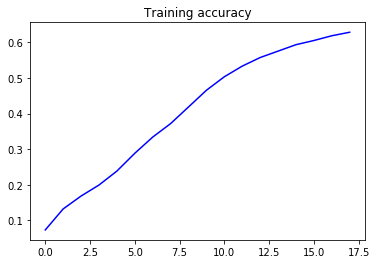

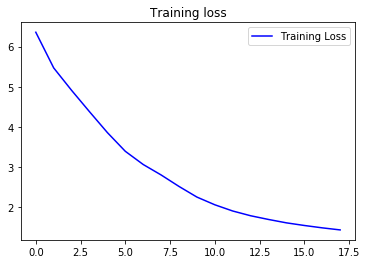

In [ ]:
#let's look at how loss and accuracy changed while training
import matplotlib.pyplot as plt
history = model.history
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()